# Abstract

Learn how to use the Logic Tensor Networks (LTN) framework to solve visual reasoning tasks on a dataset similar to Clevr. We will build upon the LTN tutorials and resources available on the [LTN GitHub repository](https://github.com/logictensornetworks/logictensornetworks). 

# Content 



1.   Imports 
2.   Introduction
3.   Data
4.   LTN - Creation of the Knowledge Base
5.   LTN - Training  
6.   Loading of pre-trained model (Alternative to step 5 and 6)
7.   Querying of truth values for logical expressions 
8.   Performance Analysis 
9.   Question Answering Example 


# 1) Imports 



In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from matplotlib.pyplot import imread
import pickle
from itertools import product 
import cv2
import ltn
import random 
import keras
import seaborn as sns
from collections import defaultdict 
from tqdm import tqdm 
import torch
from skimage.io import imshow
import logging; logging.basicConfig(level=logging.INFO)
from IPython.display import Image

In [25]:
# import helper functions
from helper_functions import *

# 2) Introduction 





With this tutorial we want to introduce and
 bring together an archetypical framework and a benchmark in the field of Neuro Symbolic AI: LTN and a simplified version of the Clevr dataset that focuses on the visual components.

CLEVR is a 'diagnostic  dataset  that tests a range of visual reasoning abilities. It contains minimal biases and has detailed annotations describing the kind of reasoning each question requires.[...] [It can be used] to analyze a variety of modern visual reasoning systems, providing novel insights into their abilities and limitations.' ([CLEVR paper](https://arxiv.org/abs/1612.06890)) The [simplified version](https://github.com/nerdimite/neuro-symbolic-ai-soc) differs in that it contains a 2D scene with exactly 6 objects which can have one out of two shapes and one out of six different colours. (See chapter 3)

The LTN-solution is based on Multi-Class Multi-Label classification  and guarded quantifiers which have been introduced in a previous [example](https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/multiclass_classification/multiclass-multilabel.ipynb) and [tutorial](https://github.com/logictensornetworks/logictensornetworks/blob/master/tutorials/2-grounding_connectives.ipynb) respectively. On this basis the LTN learns to identify absolute attributes of objects, their shape and colour, as well as the relative axiom 'left of', which expresses that an object is to the left of another object. The trained LTN is then used to evaluate the the truth values for logical expressions and answer questions about objects. The latler is visualized in the following figure. 


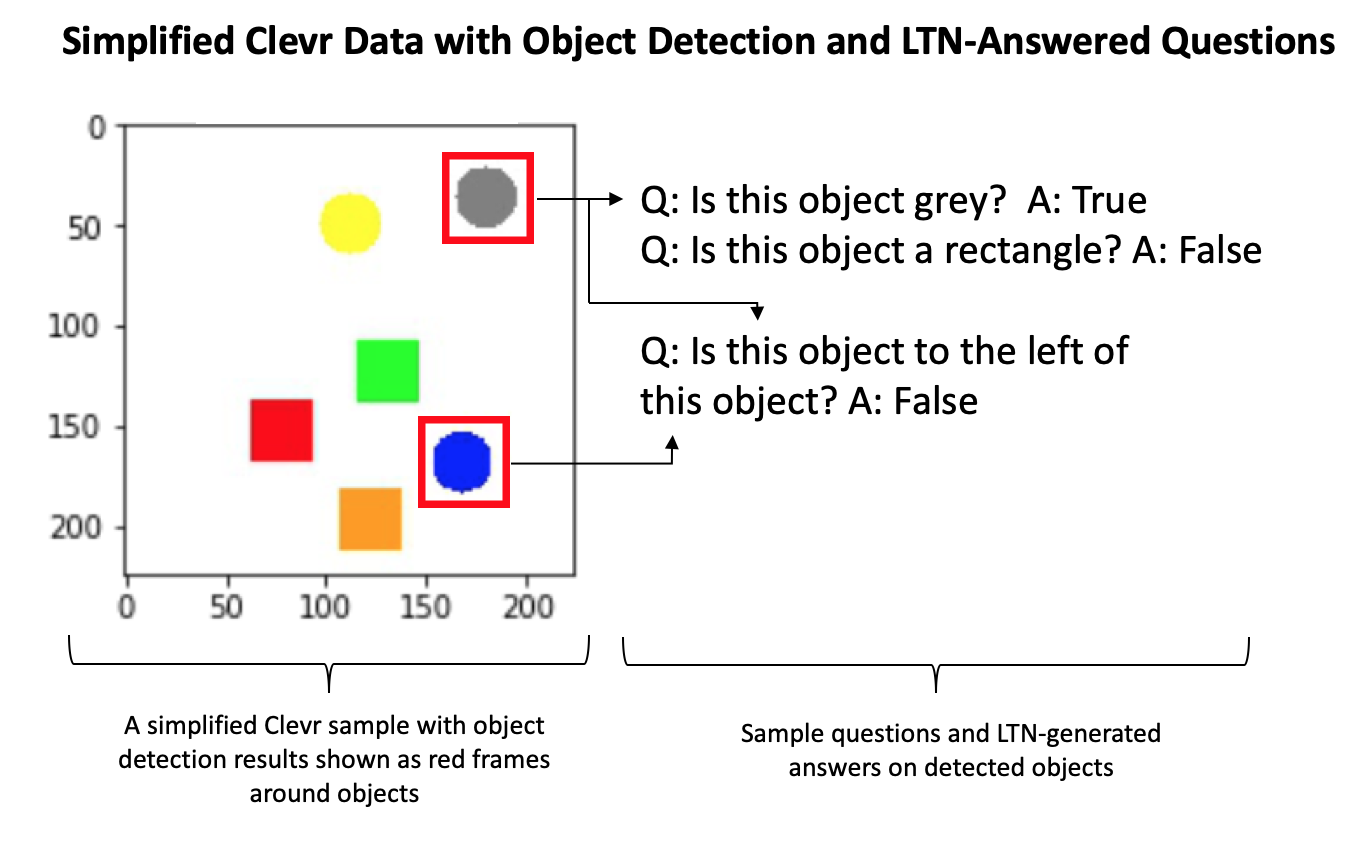

In [26]:
img_path ="Figure 2 Simplified Clevr Detector and LTN.png"
Image(img_path,width=500)

# 3) Data 




The dataset we are working with has undergone pre-processing using an object -detector to identify objects in the images. This pre-processing step allows us to focus on the application of the LTN. For a visualization of the output of the detector, please see the figure in section 2) in which the output is visualized as a red frame around objects.

The resulting dataframe contains the following information for each detected object:
- Information about the original image:
  - The original image (stored in the 'original_image' column)
  - The identifier of the original image (stored in the 'image_name' column)

- The output from the detector for each object:

  - The image of the object (stored in the 'object_image' column)
  - The identifier for the object (stored in the 'object_nb' column)
  - The position of the object center in the original image (stored in the 'object_center' column)

- Finally, the detected objects need to be matched with their corresponding ground truth information provided in the Clevr data. The position of each detected object is compared with the object positions in the original data set. The ground truth information of the object closest to the detected one is assigned.
  - The color of the object (stored in the 'color' column)
  - The shape of the object (stored in the 'color' column)

In [27]:
# Import the dataset 

# location of the preprocessed data
data_preprocessed ="pre_processed_data/"

# import the data 
with open(data_preprocessed+"dataset_on_bounding_box_level", "rb") as fp:   # Unpickling
  dataset_on_bounding_box_level = pickle.load(fp)

In [28]:
# Data Overview
summarize_imported_dataset_on_object_level(dataset_on_bounding_box_level)

There are 6000 training examples
with the following information: ['image_name', 'original_image', 'object_nb', 'object_image', 'object_center', 'color', 'shape']
For the attribute color there are 6 possible values
For the attribute shape there are 2 possible values


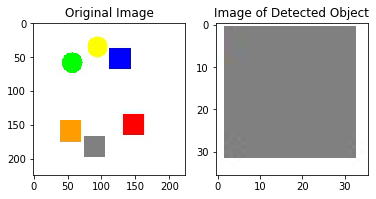

Position of the object center in original image: (91, 184)
Ground truth of the object's color: grey
Ground truth of the object's shape: rectangle


In [29]:
# Visualizing a Random Example
example = np.random.randint(0,len(dataset_on_bounding_box_level))
visualize_example(dataset_on_bounding_box_level[example])

In [30]:
# Change format of data set to be of a tensorflow dataset and rescale images to be of the same size 
ds_train,ds_test = from_bounding_boxes_list_to_ds_training_and_test(dataset_on_bounding_box_level,batch_size= 32,split_thr=0.8,
                                                 col_to_reshape = "object_image",resize_shape =(36, 36))

we split after 4800 samples into train + test
Tensorflow Dataset for LTN is prepared


# 4) LTN - Creation of the Knowledge Bases 

Note: As an alternative, step 6 can be completed instead of steps 4 and 5.

## Definition of the building blocks for the axioms 

The following code cells prepare the writing of the knowledge base. They contain definitions for constants, logical operators, and predicates. These are the 'building blocks' of the axioms that will make up the knowledge base.

(For information on knowledge bases in LTN please see this [tutorial](https://github.com/logictensornetworks/logictensornetworks/blob/master/tutorials/3-knowledgebase_and_learning.ipynb).)

In the following cell, constants are defined. In our case each of them represent a class, a visual concept, that can be assigned to images of objects. This happens in a similar way as shown in [Multi-Class Multi-Label classification example](https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/multiclass_classification/multiclass-multilabel.ipynb).

In [31]:
# define constants 
class_darkblue = ltn.Constant(0, trainable=False)
class_green = ltn.Constant(1, trainable=False)
class_red = ltn.Constant(2, trainable=False)
class_babyblue = ltn.Constant(3, trainable=False)
class_grey = ltn.Constant(4, trainable=False)
class_lightblue = ltn.Constant(5, trainable=False)
class_circle = ltn.Constant(6, trainable=False)
class_rectangle = ltn.Constant(7, trainable=False)

# define pairs of constants for easier handling
combis_colors_previous = [(a, b) for idx, a in enumerate([class_darkblue,class_green,class_red,class_babyblue, # provisional solution
                                                     class_grey,class_lightblue]) for b in [class_darkblue,class_green,class_red,class_babyblue,
                                                     class_grey,class_lightblue][idx + 1:]]

In the following cell, logical operators get defined. The same definitions as in [Multi-Class Multi-Label classification example](https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/multiclass_classification/multiclass-multilabel.ipynb) have been used with the addition of the 'Exists' operator. 

In [32]:
# define logical operators
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum()) 
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=5),semantics="exists") 
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))


In the following cell, predicates are defined. 

These predicates are used to describe the characteristics and relationships of objects, the absolute and relative attributes. 

The absolute attributes of an object, the color and shape, are defined using the 'absolute_object_attribute' predicate. This predicate is based on the visual information about the objects and thus build up on a Convolutional Neural Network.

The relative attributes of a pair of objects (x,y), the relationship "x is left of y," are defined using the 'to_the_left' predicate. This predicate is based on the location of the objects in the images and build up on a Neural Network.

In [33]:
# Define the predicates 
# absolute attributes
absolute_object_attributes_nn = CNN_simple(8) 
absolute_object_attributes_predicate = ltn.Predicate(ltn.utils.LogitsToPredicateModel(absolute_object_attributes_nn,single_label=False)) 

# relative attributes
to_the_left_nn = Simple_keras_with_concatentation_left_of()
to_the_left_predicate = ltn.Predicate(to_the_left_nn)

# for easier handline create a dictionary with the nn and predicates 
predicates_and_nn = {'absolute_object_attributes_predicate': absolute_object_attributes_predicate,
                       'absolute_object_attributes_nn': absolute_object_attributes_nn,
                       'to_the_left_predicate':to_the_left_predicate ,
                       'to_the_left_nn':to_the_left_nn}

## Writing of the Knowledge Base 

In the following cell, the axioms get defined on the basis of the previously defined 'building blocks'. The combination of the axioms is the knowledge base. 



For the absolute attributes the following steps are used: 

1.  **Definition of variables**:  image features of the samples get assigned to variables depending on their ground truth, e.g. the image of a green object get assigned to the variable x_green 
2.  **Definition of membership axioms**: based on the defined variables the membership axioms can be read as follows - here again exemplary for the green objects-   'For all images containing green objects, the absolute_object_attributes predicate should return a high satisfiability if  the image get's passed to the predicate together with the constant representing the green class'.
3.  **Definition of the exclusivity axioms**: in order to prevent the absolute_object_attributes predicate to simply always return a high satisfiability, the exclusivity axioms adds that an image can only be classified as one shape and one color. Such an axioms can be read as for example 'For all images, the absolute_object_attributes fed with a constant representing the green class and absolute_object_attributes fed with a constant representing the red class can't be both result in a high satisfiability'

For the relative attribut 'left_of' the following steps are used: 

1.  **Definition of variables**: as a result of the relative nature of this axiom, it is not sufficient to define only one variable. Two variables are needed, that are defined in a relative relationship: one variable, the x_l_item, is to the left of the other, the x_r_item. 

2.  **Definition of the positive axioms**: the variables are fed in the correct order, first the x_l_item and then the x_r_item, into the 'left_of' predicate which is supposed to result in a high satisfiability 
3.  **Definition of the negative axioms**: again, to prevent the 'left_of' predicate from simply always outputting a high satisfiability, the respective negative example with the reversed order of inputs is provided

Note: In step 2) and 3) of the relative axiom, a mask could have been used to combine these steps together as described in the [tutorial](https://github.com/logictensornetworks/logictensornetworks/blob/master/tutorials/2-grounding_connectives.ipynb). 

In [34]:
# creat the knowledge base
@tf.function
def axioms(img_name,img_features,labels_shape,labels_color,location_feature):   
    # define variables for absolute object attributes
    x = ltn.Variable("x",img_features)
    x_darkblue = ltn.Variable("x_darkblue",img_features[labels_color==0])
    x_green = ltn.Variable("x_green",img_features[labels_color==1])
    x_red = ltn.Variable("x_red",img_features[labels_color==2])
    x_babyblue = ltn.Variable("x_babyblue",img_features[labels_color==3])
    x_grey = ltn.Variable("x_grey",img_features[labels_color==4])
    x_lightblue = ltn.Variable("x_lightblue",img_features[labels_color==5])
    x_circle = ltn.Variable("x_circle",img_features[labels_shape==6])
    x_rectangle = ltn.Variable("x_rectangle",img_features[labels_shape==7])

    # define variables for relative attributes (here only: 'left of' attribute) 
    # this happens in three steps: 
    # 1) potential pairs of objects are formed based on their location features
    # 2) the potential pairs are filtered for two conditions: that they belong to the same image and that the first item is indeed to the left of the right item
    # 3) splitting of the left and right items into their own variable (this steps enables easier handling once the predicate is trained and applied on new data)

    # Step 1)
    l_r_candidate_pairs = [(location_feature[l],location_feature[r]) for l in range(len(img_name)) for r in range(len(img_name))] # get all possible combinations of 2 objects
    # Step 2) 
    tf_img_name_filter = [tf.equal(img_name[l],img_name[r]) for l in range(len(img_name)) for r in range(len(img_name))] # first condition
    tf_x_comparison_filter = [tf.math.less(location_feature[l][0],location_feature[r][0]) for l in range(len(img_name)) for r in range(len(img_name))] # second condition
    l_r_pairs_filtered = tf.gather(l_r_candidate_pairs, tf.where(tf.math.logical_and(tf_img_name_filter, tf_x_comparison_filter))) # filtering on the 2 conditions 
    # Step 3) 
    # the following split into left and right items will require diagonal quantification in the axiom. 
    # Please see the following tutorial for more information on the diagonal quantification: https://github.com/logictensornetworks/logictensornetworks/blob/master/tutorials/2-grounding_connectives.ipynb
    x_l_items = ltn.Variable("x_l_items",tf.slice(l_r_pairs_filtered, [0, 0, 0, 0], [-1,1,1, 1])) # to get the left objects 
    x_r_items = ltn.Variable("x_r_items",tf.slice(l_r_pairs_filtered, [0, 0, 1, 0], [-1,1,1, 1])) # to get the right objects 

    axioms = [
        # ABSOLUTE ATTRIBUTE CASES 
        ## colours and shape membership axioms
        Forall(x_darkblue, absolute_object_attributes_predicate([x_darkblue,class_darkblue])), 
        Forall(x_green, absolute_object_attributes_predicate([x_green,class_green])),
        Forall(x_red, absolute_object_attributes_predicate([x_red,class_red])),
        Forall(x_babyblue, absolute_object_attributes_predicate([x_babyblue,class_babyblue])),
        Forall(x_grey, absolute_object_attributes_predicate([x_grey,class_grey])),
        Forall(x_lightblue, absolute_object_attributes_predicate([x_lightblue,class_lightblue])),
        Forall(x_circle, absolute_object_attributes_predicate([x_circle,class_circle])),
        Forall(x_rectangle, absolute_object_attributes_predicate([x_rectangle,class_rectangle])),
        
        # exclusivity axiom for shape (see below for the exclusivity axiom for colour)
        Forall(x,Not(And(absolute_object_attributes_predicate([x,class_circle]),absolute_object_attributes_predicate([x,class_rectangle])))),
 
        # RELATIVE ATTRIBUTE CASES 
        Forall(ltn.diag(x_l_items,x_r_items), to_the_left_predicate([x_l_items,x_r_items])),  # positive case 
        Forall(ltn.diag(x_l_items,x_r_items), Not(to_the_left_predicate([x_r_items,x_l_items])))  # negative case 
    ]

    # exclusivity for colour (axioms get appended to the axioms list, written this way for better readability ) 
    for combi in combis_colors_previous[::-1]: 
      axioms.append( Forall(x,Not(And(absolute_object_attributes_predicate([x,combi[0]]),absolute_object_attributes_predicate([x,combi[1]])))))

    kb = formula_aggregator(axioms)
    sat_level = kb.tensor
    return sat_level 

In [35]:
# initialize the layers
for img_name,img_features, labels_shape, labels_color,location_feature in ds_train: 
    print("Initial sat level %.5f"%axioms(img_name,img_features,labels_shape,labels_color,location_feature))
    break

Initial sat level 0.61550


# 5) LTN - Training

Note: As an alternative, step 6 can be completed instead of steps 4 and 5.




## Define the Metrics
During training, we want to evaluate the following metrics on both the training and test datasets:

- Satisfiability of the Knowledge Base
- Accuracy of the absolute attributes
- Satisfiability of formulas related to the 'left of' predicate

These metrics are defined as individual functions in the next cell. They are identical to the individual axioms in the knowledge base. This allows us to analyze the satisfiability of each axiom individually.


In [36]:
# define a meassure for the accuracy of the absolute attribute 
def multilabel_hamming_loss(y_true, y_pred, threshold=0.5,from_logits=False):                                                                                
    if from_logits:
        y_pred = tf.math.sigmoid(y_pred)
    y_pred = y_pred > threshold
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    nonzero = tf.cast(tf.math.count_nonzero(y_true-y_pred,axis=-1),tf.float32)
    return nonzero/y_true.get_shape()[-1]

def absolute_attribute_train_accuracy(prediction,loss,labels_color,labels_shape):
  labels_darkblue = (labels_color==0)  
  labels_green = (labels_color==1)
  labels_red = (labels_color==2)
  labels_babyblue = (labels_color==3)
  labels_grey = (labels_color==4)
  labels_lightblue = (labels_color==5)
  labels_circle = (labels_shape==6)
  labels_rectangle = (labels_shape==7)
  onehot = tf.stack([labels_darkblue,labels_green,labels_red,labels_babyblue,labels_grey,labels_lightblue, 
                      labels_circle,labels_rectangle],axis=-1)
  return 1-loss(onehot,prediction,from_logits=True)

@tf.function
def axiom_is_left_of_pos(img_name,location_feature,predicates_and_nn):
  # define variables for relative attributes (here only: 'left of' attribute) 
  l_r_candidate_pairs = [(location_feature[l],location_feature[r]) for l in range(len(img_name)) for r in range(len(img_name))] # all possible combinations of 2 objects
  tf_img_name_filter = [tf.equal(img_name[l],img_name[r]) for l in range(len(img_name)) for r in range(len(img_name))] # first condition
  tf_x_comparison_filter = [tf.math.less(location_feature[l][0],location_feature[r][0]) for l in range(len(img_name)) for r in range(len(img_name))] # second condition
  l_r_pairs_filtered = tf.gather(l_r_candidate_pairs, tf.where(tf.math.logical_and(tf_img_name_filter, tf_x_comparison_filter))) # filtering on the 2 conditions 
  # split into left + right objects --> they are to be used with diagonal quantification  
  x_l_items = ltn.Variable("x_l_items",tf.slice(l_r_pairs_filtered, [0, 0, 0, 0], [-1,1,1, 1])) # to get the left objects 
  x_r_items = ltn.Variable("x_r_items",tf.slice(l_r_pairs_filtered, [0, 0, 1, 0], [-1,1,1, 1])) # to get the right objects 
  pos_res = Forall(ltn.diag(x_l_items,x_r_items), predicates_and_nn['to_the_left_predicate']([x_l_items,x_r_items])).tensor  # positive case 
  return pos_res

@tf.function
def axiom_is_left_of_neg(img_name,location_feature,predicates_and_nn):
  # define variables for relative attributes (here only: 'left of' attribute)
  l_r_candidate_pairs = [(location_feature[l],location_feature[r]) for l in range(len(img_name)) for r in range(len(img_name))] # all possible combinations of 2 objects
  tf_img_name_filter = [tf.equal(img_name[l],img_name[r]) for l in range(len(img_name)) for r in range(len(img_name))] # first condition
  tf_x_comparison_filter = [tf.math.less(location_feature[l][0],location_feature[r][0]) for l in range(len(img_name)) for r in range(len(img_name))] # second condition
  l_r_pairs_filtered = tf.gather(l_r_candidate_pairs, tf.where(tf.math.logical_and(tf_img_name_filter, tf_x_comparison_filter))) # filtering on the 2 conditions 
  # split into left + right objects --> they are to be used with diagonal quantification  
  x_l_items = ltn.Variable("x_l_items",tf.slice(l_r_pairs_filtered, [0, 0, 0, 0], [-1,1,1, 1])) # to get the left objects 
  x_r_items = ltn.Variable("x_r_items",tf.slice(l_r_pairs_filtered, [0, 0, 1, 0], [-1,1,1, 1])) # to get the right objects 
  neg_res = Forall(ltn.diag(x_l_items,x_r_items), Not(predicates_and_nn['to_the_left_predicate']([x_r_items,x_l_items]))).tensor
  return neg_res




## Define the Training Functions

In the following cell, two functions are defined: a train step and a test step. These functions are then brought together in the training function which also takes care of tracking the learning progress via the above defined metrics. This process follows the [Multi-Class Multi-Label classification example](https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/multiclass_classification/multiclass-multilabel.ipynb)

In [37]:
import absl.logging  
absl.logging.set_verbosity(absl.logging.ERROR)

In [38]:
# Create a function that creates the test and training steps 
@tf.function
def train_step(img_name,img_features, labels_shape, labels_color,location_feature,axioms,metrics_dict,predicates_and_nn,trainable_predicates,optimizer):
  # Function code goes here
  # evaluate the satisfiability and update the trainable variables accordingly
  with tf.GradientTape() as tape:
      sat = axioms(img_name,img_features, labels_shape, labels_color,location_feature)
      loss = 1.-sat
  list_all_trainable_variables = []
  
  for pred in trainable_predicates: 
      list_all_trainable_variables += predicates_and_nn[pred].trainable_variables
  gradients = tape.gradient(loss, list_all_trainable_variables) 
  optimizer.apply_gradients(zip(gradients, list_all_trainable_variables))
  
  # fill the metrics dictionary if applicable 
  metrics_dict['train_sat_kb'](sat)
  predictions = predicates_and_nn['absolute_object_attributes_nn'](img_features) 
  metrics_dict['train_absolut_attribute_accuracy'](absolute_attribute_train_accuracy(prediction=predictions,loss=multilabel_hamming_loss,labels_color=labels_color,
                                                      labels_shape=labels_shape))
  metrics_dict['train_to_the_left_of_pos_case'](axiom_is_left_of_pos(img_name,location_feature,predicates_and_nn))
  metrics_dict['train_to_the_left_of_neg_case'](axiom_is_left_of_neg(img_name,location_feature,predicates_and_nn))
 
@tf.function
def test_step(img_name,img_features, labels_shape, labels_color,location_feature,axioms,metrics_dict,predicates_and_nn):
  # evaluate the satisfiability 
  sat_kb = axioms(img_name,img_features, labels_shape, labels_color,location_feature)

  # fill the metrics dictionary if applicable  
  metrics_dict['test_sat_kb'](sat_kb)
  predictions = predicates_and_nn['absolute_object_attributes_nn'](img_features)
  metrics_dict['test_absolut_attribute_accuracy'](absolute_attribute_train_accuracy(prediction=predictions,loss=multilabel_hamming_loss,labels_color=labels_color,
                                                    labels_shape=labels_shape))
  metrics_dict['test_to_the_left_of_pos_case'](axiom_is_left_of_pos(img_name,location_feature,predicates_and_nn))
  metrics_dict['test_to_the_left_of_neg_case'](axiom_is_left_of_neg(img_name,location_feature,predicates_and_nn))



In [39]:
# bring train_step and test_step togetehr in the train function and track the progress made durign the learning
def train(epochs,metrics_dict, ds_train,  ds_test,  train_step, test_step,path_for_model_and_opt_save,axioms,
          predicates_and_nn,trainable_predicates,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),save_nn=None,track_metrics=1,csv_path=None):

    # initialize parameter
    best_val_score = 0.0
    early_counter = 0
    early = None 
    
    # create a csv to save the metrics
    template = "Epoch {} \n"
    for metrics_label in metrics_dict.keys():
        template += "%s: {:.4f} \n" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    # iterate over the epochs, get metrices and conduct training and testing steps
    for epoch in tqdm(range(epochs)):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train: 
            train_step(*batch_elements,axioms,metrics_dict,predicates_and_nn,trainable_predicates,optimizer)

        for batch_elements in ds_test:  
            test_step(*batch_elements,axioms,metrics_dict,predicates_and_nn)

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
         # save best model and update early stop counter, if necessary   (meassured on test_sat_kb)
        if list(metrics_dict.values())[1].result().numpy() > best_val_score:
            best_val_score = list(metrics_dict.values())[1].result().numpy()
            early_counter = 0
            if save_nn is not None: 
              torch.save({
              'optimizer_state_dict': optimizer.get_config() 
                    }, path_for_model_and_opt_save + "optimizer_epoch_" +str(epoch) )
              for k,v in save_nn.items():
                v.save(path_for_model_and_opt_save+ k+"_epoch_" +str(epoch) ) 
        else:
            early_counter += 1
            if early is not None and early_counter > early:
                print("Training interrupted due to early stopping")
                break
    if csv_path is not None:
        csv_file.close()

In [40]:
# define a dictionary that holds the evaluation metrics 
metrics_dict = {
    # satisfiability of the knowledge base 
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    # absolute attribute
    'train_absolut_attribute_accuracy': tf.keras.metrics.Mean(name="train_absolut_attribute_accuracy"),
    'test_absolut_attribute_accuracy': tf.keras.metrics.Mean(name="test_absolut_attribute_accuracy"),
    # to the left 
    'train_to_the_left_of_pos_case':tf.keras.metrics.Mean(name="train_to_the_left_of_pos_case"),
    'train_to_the_left_of_neg_case':tf.keras.metrics.Mean(name="train_to_the_left_of_neg_case"),
    'test_to_the_left_of_pos_case':tf.keras.metrics.Mean(name="test_to_the_left_of_pos_case"),
    'test_to_the_left_of_neg_case':tf.keras.metrics.Mean(name="test_to_the_left_of_neg_case")
   }


## Run the training

Please note that the training can take a substantial amount of time. Step 6) loads a pre-trained version and can be used as an alternative eto step 4) and 5). 

In [41]:
# Set epoch number and path of folder where models get saved to
EPOCHS = 10
path_for_model_and_opt_save = "pre_learned_models/"

# call the train function
# during the training the evaluation metrics are getting printed to get direct feedback. For better readability, please see the csv file that get's written during the process
train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    path_for_model_and_opt_save=path_for_model_and_opt_save,
    axioms=axioms,
    predicates_and_nn=predicates_and_nn,
    trainable_predicates = ['absolute_object_attributes_predicate','to_the_left_predicate'],
    save_nn = {'absolute_object_attributes_nn':absolute_object_attributes_nn,'to_the_left_nn':to_the_left_nn} ,
    csv_path=path_for_model_and_opt_save+"metrics.csv", 
    track_metrics=1
) 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 
train_sat_kb: 0.8119 
test_sat_kb: 0.8432 
train_absolut_attribute_accuracy: 0.9374 
test_absolut_attribute_accuracy: 0.9696 
train_to_the_left_of_pos_case: 0.5668 
train_to_the_left_of_neg_case: 0.4242 
test_to_the_left_of_pos_case: 0.5595 
test_to_the_left_of_neg_case: 0.5018 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_0/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_0/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_0/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_0/assets
 10%|█         | 1/10 [04:25<39:45, 265.02s/it]

Epoch 1 
train_sat_kb: 0.8518 
test_sat_kb: 0.8618 
train_absolut_attribute_accuracy: 0.9685 
test_absolut_attribute_accuracy: 0.9698 
train_to_the_left_of_pos_case: 0.5850 
train_to_the_left_of_neg_case: 0.5594 
test_to_the_left_of_pos_case: 0.6158 
test_to_the_left_of_neg_case: 0.6115 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_1/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_1/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_1/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_1/assets
 20%|██        | 2/10 [05:39<20:24, 153.07s/it]

Epoch 2 
train_sat_kb: 0.8676 
test_sat_kb: 0.8754 
train_absolut_attribute_accuracy: 0.9683 
test_absolut_attribute_accuracy: 0.9698 
train_to_the_left_of_pos_case: 0.6447 
train_to_the_left_of_neg_case: 0.6455 
test_to_the_left_of_pos_case: 0.6727 
test_to_the_left_of_neg_case: 0.6803 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_2/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_2/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_2/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_2/assets
 30%|███       | 3/10 [06:53<13:38, 116.95s/it]

Epoch 3 
train_sat_kb: 0.8852 
test_sat_kb: 0.8926 
train_absolut_attribute_accuracy: 0.9771 
test_absolut_attribute_accuracy: 0.9792 
train_to_the_left_of_pos_case: 0.6935 
train_to_the_left_of_neg_case: 0.7009 
test_to_the_left_of_pos_case: 0.7170 
test_to_the_left_of_neg_case: 0.7267 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_3/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_3/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_3/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_3/assets
 40%|████      | 4/10 [08:10<10:07, 101.19s/it]

Epoch 4 
train_sat_kb: 0.8955 
test_sat_kb: 0.8993 
train_absolut_attribute_accuracy: 0.9792 
test_absolut_attribute_accuracy: 0.9792 
train_to_the_left_of_pos_case: 0.7319 
train_to_the_left_of_neg_case: 0.7400 
test_to_the_left_of_pos_case: 0.7517 
test_to_the_left_of_neg_case: 0.7598 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_4/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_4/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_4/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_4/assets
 50%|█████     | 5/10 [09:26<07:39, 91.84s/it] 

Epoch 5 
train_sat_kb: 0.9034 
test_sat_kb: 0.9381 
train_absolut_attribute_accuracy: 0.9803 
test_absolut_attribute_accuracy: 0.9997 
train_to_the_left_of_pos_case: 0.7620 
train_to_the_left_of_neg_case: 0.7682 
test_to_the_left_of_pos_case: 0.7807 
test_to_the_left_of_neg_case: 0.7846 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_5/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_5/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_5/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_5/assets
 60%|██████    | 6/10 [10:41<05:44, 86.20s/it]

Epoch 6 
train_sat_kb: 0.9423 
test_sat_kb: 0.9475 
train_absolut_attribute_accuracy: 1.0000 
test_absolut_attribute_accuracy: 1.0000 
train_to_the_left_of_pos_case: 0.7914 
train_to_the_left_of_neg_case: 0.7950 
test_to_the_left_of_pos_case: 0.8105 
test_to_the_left_of_neg_case: 0.8112 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_6/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_6/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_6/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_6/assets
 70%|███████   | 7/10 [12:02<04:14, 84.67s/it]

Epoch 7 
train_sat_kb: 0.9487 
test_sat_kb: 0.9531 
train_absolut_attribute_accuracy: 0.9999 
test_absolut_attribute_accuracy: 1.0000 
train_to_the_left_of_pos_case: 0.8160 
train_to_the_left_of_neg_case: 0.8172 
test_to_the_left_of_pos_case: 0.8313 
test_to_the_left_of_neg_case: 0.8308 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_7/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_7/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_7/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_7/assets
 80%|████████  | 8/10 [13:22<02:46, 83.04s/it]

Epoch 8 
train_sat_kb: 0.9539 
test_sat_kb: 0.9574 
train_absolut_attribute_accuracy: 1.0000 
test_absolut_attribute_accuracy: 1.0000 
train_to_the_left_of_pos_case: 0.8338 
train_to_the_left_of_neg_case: 0.8341 
test_to_the_left_of_pos_case: 0.8470 
test_to_the_left_of_neg_case: 0.8462 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_8/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_8/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_8/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_8/assets
 90%|█████████ | 9/10 [14:40<01:21, 81.64s/it]

Epoch 9 
train_sat_kb: 0.9577 
test_sat_kb: 0.9609 
train_absolut_attribute_accuracy: 1.0000 
test_absolut_attribute_accuracy: 1.0000 
train_to_the_left_of_pos_case: 0.8476 
train_to_the_left_of_neg_case: 0.8475 
test_to_the_left_of_pos_case: 0.8595 
test_to_the_left_of_neg_case: 0.8587 

INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_9/assets


INFO:tensorflow:Assets written to: pre_learned_models/absolute_object_attributes_nn_epoch_9/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_9/assets


INFO:tensorflow:Assets written to: pre_learned_models/to_the_left_nn_epoch_9/assets
100%|██████████| 10/10 [15:59<00:00, 95.91s/it]


# 6) Loading Pre-trained models 

This step is an alternative to step 5) and 6). 

In [42]:
# function to load pre-trained models
def load_pre_learned_nn_and_predicates(model_folder_path, dict_nn_to_load):
  return_dict = {} # dictionary to store the nn and predicates

  # iterrate over names and locations of the pre-learned neural networks
  for k,v in dict_nn_to_load.items(): 
    if k =="absolute_object_attributes": #  for each keyword add the respective nn and create a predicate
      return_dict['absolute_object_attributes_nn']= keras.models.load_model(model_folder_path+v,compile=False)
      return_dict['absolute_object_attributes_predicate'] = ltn.Predicate(ltn.utils.LogitsToPredicateModel(return_dict['absolute_object_attributes_nn'],single_label=False)) 
      print(k,'loaded')
    if k == 'to_the_left':
      return_dict['to_the_left_nn']= keras.models.load_model(model_folder_path+v,compile=False)
      return_dict['to_the_left_predicate'] = ltn.Predicate(return_dict['to_the_left_nn'])
      print(k,'loaded')
    if k =='most_left_of':
      return_dict['absolute_object_attributes_nn']= keras.models.load_model(model_folder_path+v,compile=False)
      return_dict['absolute_object_attributes_predicate'] = ltn.Predicate(return_dict['absolute_object_attributes_nn'])
      print(k,'loaded')
    
  return return_dict


In [43]:
# define the paths
path_pre_trained_models= "pre_learned_models/"

# define the nn and predicates to be imported
dict_nn_version_to_load= {"absolute_object_attributes":'absolute_object_attributes_nn_epoch_9',
                              "to_the_left": 'to_the_left_nn_epoch_9'}

# import the pre-trained models
loaded_predicates_and_nn = load_pre_learned_nn_and_predicates(path_pre_trained_models,dict_nn_version_to_load)


absolute_object_attributes loaded
to_the_left loaded


# 7) Querying of truth values for logical expressions 

There are various ways to use the trained LTN. One way is to identify the truth value of a certain expression on unseen data, i.e. asking whether the expression holds true for the new data.

In [44]:
# load test data for assigning truth values to certain formulas 
for img_name_querying,img_features_querying, labels_shape_querying, labels_color_querying,location_feature_querying in ds_test:
  break

### Evaluate the left of relationship for an image 

We are focusing on the evaluation of the 'left of' relationship. This example can be repeated with any other data and version of the predicate and extended with any other formula.

tf.Tensor(b'800.jpg', shape=(), dtype=string)


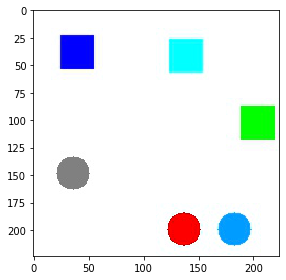

In [45]:
# visualize the first image in the dataset
print(img_name_querying[0])

# get the image level information
original_image_under_focus = [x for x in dataset_on_bounding_box_level if x['image_name']==img_name_querying[0]][0]['original_image']
imshow(cv2.cvtColor(original_image_under_focus, cv2.COLOR_BGR2RGB)) 


The following cell focuses on the preparation of the data of the selected and above visualized image. This involves filtering for pairs of objects for which the 'left_of' relationships will hold true. 

In [46]:
# filtering condition for left and right objects  (only for the first image in the test dataset)

# for visualization look at the objects 
l_r_pairs_vis = [(img_features_querying[l],img_features_querying[r]) for l in range(6) for r in range(6) 
            if ( # conditions that must be matched that we use the "left-right object pair"
              img_name_querying.numpy()[l]==img_name_querying.numpy()[r]) & ( # condition 1) objects must be from the same image
              location_feature_querying.numpy()[l][0]<location_feature_querying.numpy()[r][0]) ] # condition 2) the first object must have an x-value smaller than the 2nd object

print("There are",len(l_r_pairs_vis),"pairs for which the 'left_of' predicate is supposed to result in a high satisfiability" )

#  extract the left and right elements
l_items = [x[0] for x in l_r_pairs_vis]
r_items = [x[1] for x in l_r_pairs_vis]

# repeat the data preparation but stick with tensorflow variables for the first image 
location_feature_querying_img1 = tf.slice(location_feature_querying,[0,0],[6,-1])# limiting variables to the first image (first 6 elements)
img_name_querying_img1 = tf.slice(img_name_querying,[0],[6])# limiting variables to the first image (first 6 elements)

l_r_candidate_pairs = [(location_feature_querying_img1[l],location_feature_querying_img1[r]) for l in range(
    len(img_name_querying_img1)) for r in range(len(img_name_querying_img1))] # all possible combinations of 2 objects
tf_x_comparison_filter = [tf.math.less(location_feature_querying_img1[l][0],location_feature_querying_img1[r][0]) for l in range(
    len(img_name_querying_img1)) for r in range(len(img_name_querying_img1))] # condition
l_r_pairs_filtered = tf.gather(l_r_candidate_pairs, tf.where(tf_x_comparison_filter)) # filtering on the condition

# split into left and right object
x_l_items = ltn.Variable("x_l_items",tf.slice(l_r_pairs_filtered, [0, 0, 0, 0], [-1,1,1, 1])) # to get the left objects 
x_r_items = ltn.Variable("x_r_items",tf.slice(l_r_pairs_filtered, [0, 0, 1, 0], [-1,1,1, 1])) # to get the right objects 


There are 15 pairs for which the 'left_of' predicate is supposed to result in a high satisfiability


In the following cell, the 'left_of' predicate gets tested on the filtered pairs. First the joint satisfiability for all positive and then for all negative cases get's calculated and printed out.

In [47]:
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
print("positive logic formula", 
      Forall(ltn.diag(x_l_items,x_r_items), loaded_predicates_and_nn['to_the_left_predicate']([x_l_items,x_r_items])) ) # positive case 

print("negative logic formula",
      Forall(ltn.diag(x_l_items,x_r_items), Not(loaded_predicates_and_nn['to_the_left_predicate']([x_r_items,x_l_items]))))  # negative case 


positive logic formula ltn.Formula(tensor=0.8272610306739807, free_vars=[])
negative logic formula ltn.Formula(tensor=0.8271067142486572, free_vars=[])


To make the above more tangible, two arbitrary objects from the selected image get chosen in the next code cell. Based on the selected pair, the satisfiability of the 'left of' relationship is tested. 

It is observable, that the relationship is more vague (close to 0.5) for pairs consisting out of twice the same object (e.g. id_left = 0 and id_right =2) or objects that lie close to each other on the x-axis (e.g. id_left = 0 and id_right = 4) 

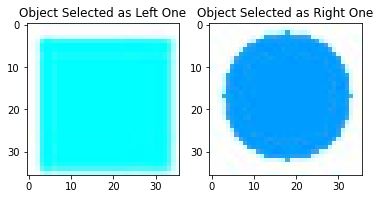

Satisfiability of the positive "left of" axiom on this pair 0.939364


In [48]:
# choose  objects from the left and right lists and see whether the logical expression holds
id_left = 0
id_right = 0
# when corresponding ids are selected, the satisfiabiltiy should be close to 1

f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.cvtColor(l_items[id_left].numpy(), cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(r_items[id_right].numpy(), cv2.COLOR_BGR2RGB))
axarr[0].title.set_text('Object Selected as Left One')
axarr[1].title.set_text('Object Selected as Right One')
plt.show()

print('Satisfiability of the positive "left of" axiom on this pair',loaded_predicates_and_nn['to_the_left_predicate'](
                                                          [ltn.Constant(x_l_items.tensor[id_left],trainable=False),
                                                           ltn.Constant(x_r_items.tensor[id_right],trainable=False)]).tensor.numpy())

# 8) Performance Analysis 



In this section we want to analyze the evolution of the metrics throughout the training process. 

<AxesSubplot:xlabel='Epoch'>

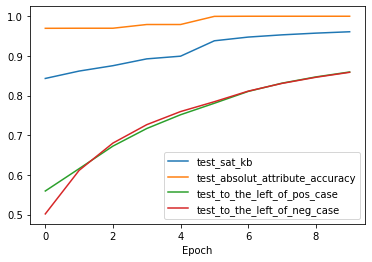

In [49]:
# define the path
path_metrics_tracking= "pre_learned_models/metrics.csv"

# import the trackings from pretrained models
tracking = pd.read_csv(path_metrics_tracking,index_col=0)

# visualize the metrics that are based on the test set 
tracking[[x for x in list(tracking.columns) if 'test' in x]].plot()

From the above plot it can be seen that the absolute attributes (orange curve) reaches a satisfiability of approximately 1 early on. The relative attributes, however, start at a low satisfiability of roughly 0.6 and steadily increase over the ten epochs to a satisfiability of about 0.85. The overal satisfiability of the knowledge base as a combination of all axioms is thus also increasing and reaches a level of more than 0.95.

# 9) Use LTN for question answering 


In this section the trained LTN is used to query answers for questions. The questions are based on the 'absolute object attribute' predicate and 'left of' predicate. They include for example 'Is there a green rectangle?', 'Which objects are left of another certain object?'


## Prepare the data

In [50]:
# put data into a df for easier handling + rescale images to same size

df_qa = pd.DataFrame(dataset_on_bounding_box_level[-60:]) # select 10 last images from the dataset (e.g. from the test set)
df_qa["object_image_rescaled"] = df_qa["object_image"].apply(lambda x: cv2.resize(x, dsize=(36, 36), interpolation=cv2.INTER_CUBIC))

# store class labels into a list in the right order for easier handling
color_classes = ["darkblue","green","red" ,"babyblue" , "grey" ,"lightblue" ]
shape_classes = ["circle","rectangle"]
classes_on_single_object_level_flat = color_classes+shape_classes
classes_on_single_object_level_as_lists=[color_classes,shape_classes]
dict_from_integer_to_label = {i: c for i, c in enumerate(classes_on_single_object_level_flat)}
dict_from_label_to_integer = {c: i for i, c in enumerate(classes_on_single_object_level_flat)}

try:  # change information in dataframe from integer to name
  df_qa.color = df_qa.color.apply(lambda x: dict_from_integer_to_label[x]) 
except: print("colors are already of the required form")

## Define the functions

In [51]:
def for_single_object_get_classes(vis_ft_obj,attributes_used,model,type_of_return = "labels"):
  # function that takes an object and predicts it's absolute attributes based on the passed predicate
  # classes that the predicate predicts in correct sequence
  labels_for_classes = attributes_used

  # change size + dtype to match with expected size, i.e. pretend it's a batch
  tf_const = tf.constant(vis_ft_obj, dtype=tf.float32)
  ft_expanded = tf.expand_dims(tf_const,0) 

  # logits get turned into prob, which we extract and round
  prob_for_classes = [np.round(x,2) for x in tf.math.sigmoid(model(ft_expanded)).numpy()[0]] 

  # for prob. higher than the randomly choosen threshold of 0.5 select the 
  # corresponding label   
  res_labels = [i for i,j in zip(labels_for_classes,prob_for_classes) if j >0.5]
  return res_labels if type_of_return =="labels" else prob_for_classes # return labels or porbabilities


def single_object_input_get_classes_and_gt(single_obj_input,model):
  # function that takes in the whole row from the input data 
  # input data: (contains image name, original image, identified for the object in the image, gt values, zoom + rescale of that particular image)
  # output: gt labels and classification based on only the object specific classes (not spatial, size etc. where info above scene/ other objects are needed)
  predicted_labels = for_single_object_get_classes(single_obj_input["object_image_rescaled"] ,
                                    classes_on_single_object_level_flat,model,type_of_return="labels")
  gt = list(single_obj_input[["color","shape"]].values)
  single_obj_gt_and_predicted_labels= {"gt":gt, "predicted_labels":predicted_labels}
  return single_obj_gt_and_predicted_labels


# generate a random question of a certain question type 
def create_q1_type(list_of_classes,nb_of_attr):
  # q1 type  yes/no question with nb_of_attr 
  q_1 = "Is the object list_of_single_object_attribute?"  # question template 
  random_classes = random.sample(list_of_classes, nb_of_attr) #randomly selected classes
  attributes_replacement = (" and ").join([random.choice(x) for x in random_classes]) # joining the attributes + fill them in in the right position of the question
  return q_1.replace("list_of_single_object_attribute",attributes_replacement) # return the modified question

# preparation for creating a negative samples: 
def remove_gt_attributes_from_list(attr,l): 
  res = l.copy()
  for a in attr: 
    try: res.remove(a)
    except: continue
  return res

# exemplary code for creating a nevative sample 
gt = ["circle","green"] 
neg_attribute_list = [remove_gt_attributes_from_list(gt,l) for l in classes_on_single_object_level_as_lists]


# preparation for creating a positive samples: 
def keep_only_gt_from_list(attr,l): 
  result = [[x] for x in attr]
  return result

# exemplary code for creating a positive sample 
gt = ["circle","green"] 
pos_attribute_list= keep_only_gt_from_list(gt,classes_on_single_object_level_as_lists)


def creation_of_4_versions_of_q1(gt,list_of_classes_on_single_object_level): 
  # create the 4 types of questions and respective answers as described in the above cell 
  # input: the gt and the list of attribute classes with respective attributes in there 
  # output: dict storing the question and answers based on the result
  dict_q_a = {} # to store the result

  pos_attribute_list = keep_only_gt_from_list(gt,list_of_classes_on_single_object_level)
  neg_attribute_list = [remove_gt_attributes_from_list(gt,l) for l in list_of_classes_on_single_object_level]

  dict_q_a[0]= {"question":create_q1_type(pos_attribute_list,1), "gt":True}
  dict_q_a[1]= {"question":create_q1_type(neg_attribute_list,1), "gt":False}
  dict_q_a[2]= {"question":create_q1_type(pos_attribute_list,2), "gt":True}
  dict_q_a[3]= {"question":create_q1_type(neg_attribute_list,2), "gt":False}
  return dict_q_a

# function to answer questions that start like "is there an object that"
def is_there_an_object(attr,label_prediction):  
  result = True
  for x in attr: 
    if x not in label_prediction: 
      result = False
      break 
  return result

def answer_question_based_on_predictions(q,p): 
  # function that answers the question based on the prediction 

  # identification of type of question
  if "Is the object" in q:  

    # modification of question 
    q=q.replace("Is the object","").replace("?","").strip().split("and")
    filtered_attributes =[x.strip() for x in q]

    # call of function that can answer that question
    result= is_there_an_object(filtered_attributes,p)
  
  else: 
    print ("unexplored query type")
    result= None 
  return result

def create_questions_gt_and_ltn_answers( single_object_row,list_of_classes_on_single_object_level,fct_for_q_generation,q_answer_pred,model): 
  # function that brings the image, the ground truth, question and prediction together
  gt_and_predict_ex = single_object_input_get_classes_and_gt(single_object_row,model)
  dict_w_questions_and_gt =  fct_for_q_generation(gt_and_predict_ex["gt"],list_of_classes_on_single_object_level)
  
  for k,v in dict_w_questions_and_gt.items():
    dict_w_questions_and_gt[k]["answer_based_on_prediction"] = q_answer_pred(v["question"],gt_and_predict_ex["predicted_labels"])
    dict_w_questions_and_gt[k]["correct"] = True if dict_w_questions_and_gt[k]["answer_based_on_prediction"] == v["gt"] else False 
    
  return dict_w_questions_and_gt

# evaluate with the learned predicates whether out of a pair of object the first passed object is to the left of the second one
def rel_left_of_get_gt_and_prediction(obj1,obj2,model):
    # bring the input in the right shape 
    tf_center_slected_obj = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant(obj1,dtype=tf.float32),-1),-1) ,-1) 
    tf_center_of_comparing_obj =  tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant(obj2,dtype=tf.float32),-1),-1),-1)  

    # call the model on the input, if it's return value is higher than 0.5 we assume True otherwise False
    return model([tf_center_slected_obj,tf_center_of_comparing_obj]).numpy()[0][0]

def is_x_left_of_y(obj1,obj2,model): 
  # get result wehther obj1 is left of obj2 
  res =  rel_left_of_get_gt_and_prediction(obj1.object_center,obj2.object_center,model)>0.5
  if res: 
    print('The first object passed is positioned on the left side of the second object passed')
  else: 
    print(print('The first passed object is NOT to the left of the second passed object'))

# for an image evaluate on all possible pairs if the 'left of' relationship holds
def get_gt_and_prediction_left_of(img_df,model):
  dict_gt_and_pred = {} # dict to save results 
  center_pt_pairs = [[list(x[0]),list(x[1])] for x in product(img_df["object_center"].values,repeat=2)] # all possible pairs of center points 
  # for all pairs of center points get the gt by comparing the x values and then based on the trained model
  for i,x in enumerate(center_pt_pairs):
    temp_dict = {}
    temp_dict["gt"]=x[0][0]<x[1][0]
    temp_dict["predicted"]=rel_left_of_get_gt_and_prediction(x[0],x[1],model)
    dict_gt_and_pred[str(x)]=temp_dict
  return dict_gt_and_pred



## Choose a scene for which questions will be answered.

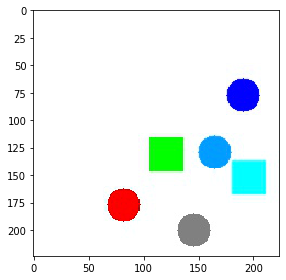

In [52]:
# select an image and visualize it: 
selected_scene_image = df_qa[df_qa.image_name =="991.jpg"]
imshow(cv2.cvtColor(selected_scene_image.iloc[0,1], cv2.COLOR_BGR2RGB)) 
plt.show()

## Questions on the absolute attributes

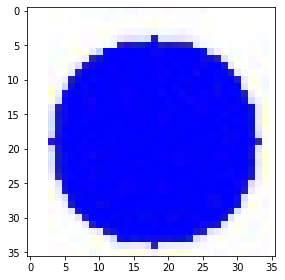

{'question': 'Is the object circle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object rectangle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object circle and darkblue?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object lightblue and rectangle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


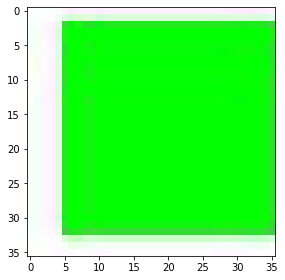

{'question': 'Is the object rectangle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object circle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object rectangle and green?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object circle and darkblue?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


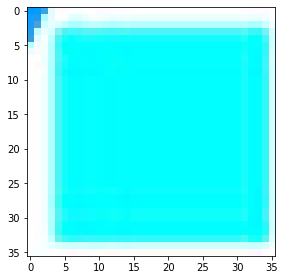

{'question': 'Is the object rectangle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object circle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object lightblue and rectangle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object circle and green?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


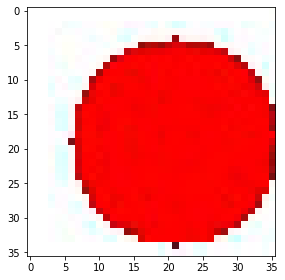

{'question': 'Is the object circle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object rectangle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object circle and red?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object rectangle and darkblue?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


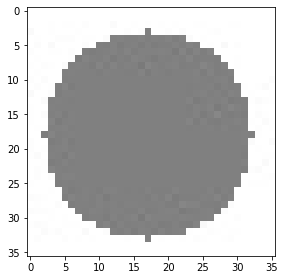

{'question': 'Is the object grey?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object lightblue?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object circle and grey?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object darkblue and rectangle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


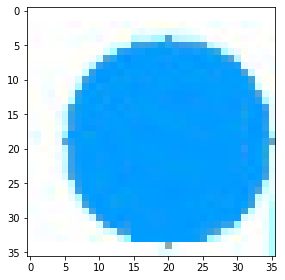

{'question': 'Is the object babyblue?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object lightblue?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}
{'question': 'Is the object babyblue and circle?', 'gt': True, 'answer_based_on_prediction': True, 'correct': True}
{'question': 'Is the object darkblue and rectangle?', 'gt': False, 'answer_based_on_prediction': False, 'correct': True}


In [53]:
# For each object generate and ask four questions about the absolute attributed of the type 'is the object ...' .
# Two questions will involve only one attribute and the other two attributes, one for the shape and one for the colour.  
# The questions are designed in such a way that for each number of attributes, one question is supposed to be answered positively and one negatively.
# Answers will be given once on the ground truth ('gt') and once based on the output of the trained LTN
for _, obj in selected_scene_image.iterrows():
  # visualize the object 
  imshow(cv2.cvtColor(obj.object_image, cv2.COLOR_BGR2RGB)) 
  plt.show()
  # generate questions, get predicitons and compare answers to the ground truth
  res = create_questions_gt_and_ltn_answers(obj,
                                                      classes_on_single_object_level_as_lists,
                                                      creation_of_4_versions_of_q1, # function that creates the questions and retrieves answer based on ground truth
                                                      answer_question_based_on_predictions,# function that answers question based on predications made
                                                      loaded_predicates_and_nn['absolute_object_attributes_nn']) # predicated used for making the predictions
  for v in res.values(): 
    print(v)
   

## Questions on the relative attribute 'left of' 

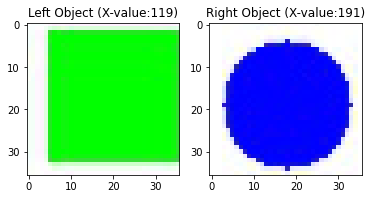

The first object passed is positioned on the left side of the second object passed


In [54]:
# select two objects, object x and object y, for which the question 'is x left of y' should be answered 
object_x = selected_scene_image.iloc[1,:]
object_y = selected_scene_image.iloc[0,:]


f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.cvtColor(object_x.object_image, cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(object_y.object_image, cv2.COLOR_BGR2RGB))
axarr[0].title.set_text('Left Object (X-value:'+str(object_x.object_center[0])+')')
axarr[1].title.set_text('Right Object (X-value:' +str(object_y.object_center[0])+')')
plt.show()

# generate the answer for the question 'is x left of y'  based on the prediction
is_x_left_of_y(object_x,object_y,loaded_predicates_and_nn['to_the_left_nn'])

In [55]:
# uncomment the following lines for retrieving the raw output of the 'left of' nn for all possible object combinations of the selected image
#res_test = get_gt_and_prediction_left_of(selected_scene_image,loaded_predicates_and_nn['to_the_left_nn'])
#res_test

### Give it a try !

Select a pair of objects and verify whether the first object is to the left of the second one. 

The object represented by object_x is depicted in the following image. Its x-value in the original image is 191


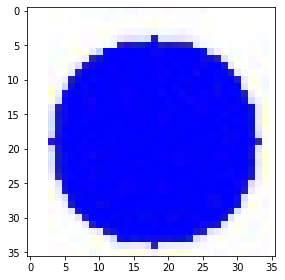

The object represented by object_y is depicted in the following image. Its x-value in the original image is 119


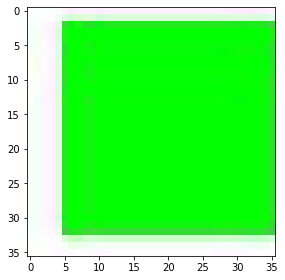

The first passed object is NOT to the left of the second passed object
None


In [57]:
# select two objects, object x and object y, for which the question 'is x left of y' should be answered 
object_x = selected_scene_image.iloc[x,:] #with x being in the range of 0 to 5
object_y = selected_scene_image.iloc[y,:] #with y being in the range of 0 to 5

# visualize the selected objects and print their x-values
print('The object represented by object_x is depicted in the following image. Its x-value in the original image is',object_x.object_center[0])
imshow(cv2.cvtColor(object_x.object_image, cv2.COLOR_BGR2RGB)) 
plt.show()

print('The object represented by object_y is depicted in the following image. Its x-value in the original image is',object_y.object_center[0])
imshow(cv2.cvtColor(object_y.object_image, cv2.COLOR_BGR2RGB)) 
plt.show()


# generate the answer for the question 'is x left of y'  based on the prediction
is_x_left_of_y(object_x,object_y,loaded_predicates_and_nn['to_the_left_nn'])